In [6]:
import os
import sys
import json
import cv2
import histomicstk as htk
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from scipy import misc
from scipy.ndimage import gaussian_filter
from PIL import Image  
import PIL 
import glob
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 


%matplotlib inline

import numpy as np
import cython

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

ModuleNotFoundError: No module named 'cv2'

C:\Users\pc\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


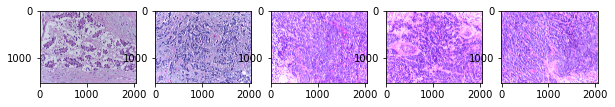

In [14]:
print "\n".join(sys.argv)

images = []

image_dir="D:\\DatasetNew\\ICIAR2018_BACH_Challenge\\Photos\\Test"

def listImagesFiles(image_dir):

    listOfFile = os.listdir(image_dir)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(image_dir, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + listImagesFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

        
        
allFiles=listImagesFiles(image_dir)        

for i, file in enumerate(allFiles):
    
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    images.append(img)        


plt.figure(figsize=(10,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

C:\Users\pc\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


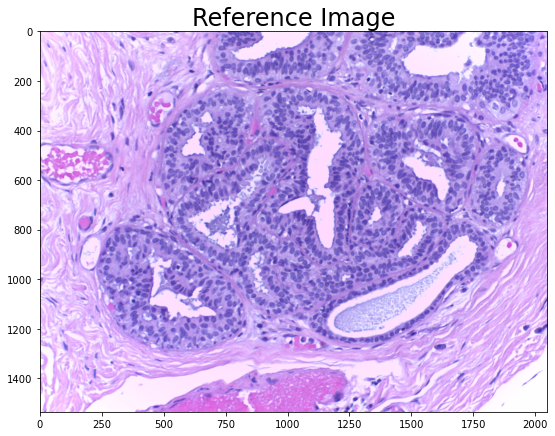

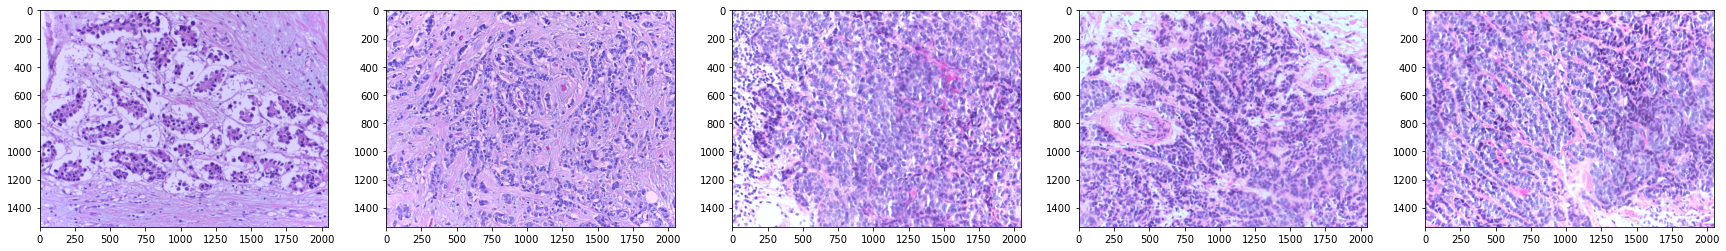

In [15]:
ref_image_file = ("D:\\DatasetNew\\ICIAR2018_BACH_Challenge\\Photos\\Benign\\b002.tif")  # L1.png

im_reference = cv2.imread(ref_image_file)
im_reference = cv2.cvtColor(im_reference, cv2.COLOR_BGR2RGB)
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# color normalization
nmzd_images = []

for i, image in enumerate(images):

    nmzd_images.append(htk.preprocessing.color_normalization.reinhard(image, mean_ref, std_ref))
    

# Display results

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)


plt.figure(figsize=(30,10))
columns = 5
for i, image in enumerate(nmzd_images):
    plt.subplot(len(nmzd_images) / columns + 1, columns, i + 1)
    plt.imshow(image)



In [ ]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

stain_1 = 'hematoxylin'   
stain_2 = 'eosin'         
stain_3 = 'null'          

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T


im_stains=[]
for i, image in enumerate(nmzd_images):
# color deconvolution
    im_stains.append(htk.preprocessing.color_deconvolution.color_deconvolution(image, W).Stains)

    
#Display results

plt.figure(figsize=(30,10))
columns = 5

for i, image in enumerate(im_stains):
    plt.subplot(len(im_stains) / columns + 1, columns, i + 1)
    plt.imshow(image[:,:,0])
    plt.title(stain_1, fontsize=titlesize)
    
plt.figure(figsize=(30,10))
columns = 5
for i, image in enumerate(im_stains):
    plt.subplot(len(im_stains) / columns + 1, columns, i + 1)
    plt.imshow(image[:,:,1])
    plt.title(stain_2, fontsize=titlesize)




In [ ]:
segmented=[]
# get nuclei/hematoxylin channel
for index, (image, image1) in enumerate(zip(im_stains, nmzd_images)):
    im_nuclei_stain = image [:, :, 0]
    # segment foreground
    foreground_threshold = 120

    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_stain < foreground_threshold)

    min_radius = 10
    max_radius = 15


    im_log_max, im_sigma_max = htk.filters.shape.cdog(
        im_nuclei_stain, im_fgnd_mask,
        sigma_min=min_radius * np.sqrt(2),
        sigma_max=max_radius * np.sqrt(2)
    )

    #segment nuclei using local maximum clustering
    local_max_search_radius = 10

    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_fgnd_mask, local_max_search_radius)

    min_nucleus_area = 50

    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int32)

    # compute nuclei properties
    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

    print ('Number of nuclei = ', len(objProps))

    #Display results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, image1, bg_label=0), origin='lower')
    plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

    plt.subplot(1, 2, 2)
    plt.imshow( image1 )
    plt.xlim([0, image1.shape[1]])
    plt.ylim([0, image1.shape[0]])
    plt.title('Nuclei bounding boxes', fontsize=titlesize)
    segmented.append(skimage.color.label2rgb(im_nuclei_seg_mask, image1, bg_label=0))
    for i in range(len(objProps)):

        c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
        width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
        height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

        cur_bbox = {
            "type":        "rectangle",
            "center":      c,
            "width":       width,
            "height":      height,
        }

        plt.plot(c[0], c[1], 'g+')
        mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                                   width, height, fill=False, ec='g', linewidth=2)
        plt.gca().add_patch(mrect)




In [6]:
datagen = ImageDataGenerator() 
for index, (image, file) in enumerate(zip(segmented, allFiles)):


    x = img_to_array(image) 
    x = x.reshape((1, ) + x.shape) 
    z = 0
    for batch in datagen.flow(x, batch_size = 1, 
                              save_to_dir ='D:\\DatasetNew\\Segmented',  
                              save_prefix =file, save_format ='tif'): 
        z += 1
        if z > 0: 
            break

print("Done")            

Done
